# **Ray: Parallel & Distributed Computing**

In [2]:
%load_ext watermark
%watermark -a 'NavinKumarMNK' -d -t -g -r -u -v -p torch

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: NavinKumarMNK

Last updated: 2023-02-12 07:22:49

Python implementation: CPython
Python version       : 3.10.8
IPython version      : 8.8.0

torch: 1.13.1

Git hash: 6a2155afd50030ec14a5646131a5dfd8b3d25a86

Git repo: https://github.com/NavinKumarMNK/MegNav.git



# **Ray Libraries**

In [14]:
import ray
import pandas as pd

## **Ray Data**

`Datasets can be transformed in parallel using .map(). Transformations are executed eagerly and block until the operation is finished. Datasets also supports .filter() and .flat_map().`

In [5]:
import ray.data as data
ds = data.range(10000)
ds

In [6]:
ds.take(5)

[0, 1, 2, 3, 4]

In [8]:
ds.schema()

int

In [10]:
ds = data.from_items([
        {"sepal.length": 5.1, "sepal.width": 3.5,
         "petal.length": 1.4, "petal.width": 0.2, "variety": "Setosa"},
        {"sepal.length": 4.9, "sepal.width": 3.0,
         "petal.length": 1.4, "petal.width": 0.2, "variety": "Setosa"},
        {"sepal.length": 4.7, "sepal.width": 3.2,
         "petal.length": 1.3, "petal.width": 0.2, "variety": "Setosa"},
     ])
ds.show()

{'sepal.length': 5.1, 'sepal.width': 3.5, 'petal.length': 1.4, 'petal.width': 0.2, 'variety': 'Setosa'}
{'sepal.length': 4.9, 'sepal.width': 3.0, 'petal.length': 1.4, 'petal.width': 0.2, 'variety': 'Setosa'}
{'sepal.length': 4.7, 'sepal.width': 3.2, 'petal.length': 1.3, 'petal.width': 0.2, 'variety': 'Setosa'}


In [12]:
ds.repartition(2)

Repartition: 100%|████████████████████████████████| 2/2 [00:00<00:00,  5.24it/s]


In [17]:
def transform_batch(df: pd.DataFrame) -> pandas.DataFrame:
    return df[(df['sepal.length'] > 4.8) & (df['sepal.width'] > 3.1)]

transformed_ds = ds.map_batches(transform_batch)
transformed_ds.show()

Map_Batches: 100%|████████████████████████████████| 3/3 [00:00<00:00,  7.56it/s]

{'sepal.length': 5.1, 'sepal.width': 3.5, 'petal.length': 1.4, 'petal.width': 0.2, 'variety': 'Setosa'}


## **Ray Distributed Train**

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim

num_samples = 20
input_size = 10
layer_size = 15
output_size = 5

torch.cuda.is_available()

True

In [41]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, layer_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(layer_size, output_size)

    def forward(self, input):
        return self.layer2(self.relu(self.layer1(input)))

inputs = torch.randn(num_samples, input_size)
labels = torch.randn(num_samples, output_size)

In [46]:
from ray import train
def train_distributed():
    num_epochs=10
    model = NeuralNetwork()
    model = train.torch.prepare_model(model)
    loss_fn = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    
    for epoch in range(num_epochs):
        out = model(inputs)
        loss = loss_fn(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"epoch: {epoch}, loss: {loss.item()}")

        

In [47]:
from ray.train.torch import TorchTrainer
from ray.air.config import ScalingConfig

trainer = TorchTrainer(
        train_distributed,
        scaling_config=ScalingConfig(
            use_gpu=False, num_workers=6
        )
    )

results = trainer.fit()

2023-02-12 07:52:46,088	INFO data_parallel_trainer.py:286 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.


(TorchTrainer pid=197977) 2023-02-12 07:52:48,345	INFO data_parallel_trainer.py:286 -- GPUs are detected in your Ray cluster, but GPU training is not enabled for this trainer. To enable GPU training, make sure to set `use_gpu` to True in your scaling config.
(RayTrainWorker pid=198044) 2023-02-12 07:52:50,869	INFO config.py:86 -- Setting up process group for: env:// [rank=0, world_size=6]


(RayTrainWorker pid=198044) epoch: 0, loss: 1.114377498626709
(RayTrainWorker pid=198044) epoch: 1, loss: 1.1105797290802002
(RayTrainWorker pid=198044) epoch: 2, loss: 1.1068446636199951
(RayTrainWorker pid=198044) epoch: 3, loss: 1.1031702756881714
(RayTrainWorker pid=198044) epoch: 4, loss: 1.09956955909729
(RayTrainWorker pid=198044) epoch: 5, loss: 1.096051812171936
(RayTrainWorker pid=198044) epoch: 6, loss: 1.0925887823104858
(RayTrainWorker pid=198044) epoch: 7, loss: 1.0891796350479126
(RayTrainWorker pid=198044) epoch: 8, loss: 1.0858298540115356
(RayTrainWorker pid=198044) epoch: 9, loss: 1.082533359527588
(RayTrainWorker pid=198045) epoch: 0, loss: 1.114377498626709
(RayTrainWorker pid=198045) epoch: 1, loss: 1.1105797290802002
(RayTrainWorker pid=198045) epoch: 2, loss: 1.1068446636199951
(RayTrainWorker pid=198045) epoch: 3, loss: 1.1031702756881714
(RayTrainWorker pid=198045) epoch: 4, loss: 1.09956955909729
(RayTrainWorker pid=198045) epoch: 5, loss: 1.096051812171936
(

(RayTrainWorker pid=198044) 2023-02-12 07:52:51,248	INFO train_loop_utils.py:270 -- Moving model to device: cpu
(RayTrainWorker pid=198044) 2023-02-12 07:52:51,248	INFO train_loop_utils.py:330 -- Wrapping provided model in DistributedDataParallel.
2023-02-12 07:52:53,538	ERROR checkpoint_manager.py:327 -- Result dict has no key: training_iteration. checkpoint_score_attr must be set to a key in the result dict. Valid keys are: ['trial_id', 'experiment_id', 'date', 'timestamp', 'pid', 'hostname', 'node_ip', 'done']


Trial TorchTrainer_232ae_00000 completed. Last result: 


2023-02-12 07:52:53,647	INFO tune.py:762 -- Total run time: 7.55 seconds (7.43 seconds for the tuning loop).


## Ray Tune HyperParameter

In [48]:
from ray import tune
def objective(config):
    score = config['a'] **2 + config['b']
    return {"score" : score}

In [49]:
search_space = {
    'a' : tune.grid_search([0.001 , 0.01, 0.1]),
    'b' : tune.choice([1, 2, 3]),
}

In [52]:
tuner = tune.Tuner(objective, param_space=search_space)
result = tuner.fit()
print(results.get_best_result(metric="score", mode='min').config)

Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,node_ip,pid,score,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
objective_c7680_00000,2023-02-12_07-57-23,True,,2657d28a78e446f19a585b635c5677b4,"0_a=0.0010,b=2",NavinKumarMNK,1,192.168.1.7,199318,2,0.000103235,0.000103235,0.000103235,1676168843,0,,1,c7680_00000,0.00199652
objective_c7680_00001,2023-02-12_07-57-24,True,,a81ec8c074414c68ac2c4964a98ccc7c,"1_a=0.0100,b=2",NavinKumarMNK,1,192.168.1.7,199382,2.0001,0.000102043,0.000102043,0.000102043,1676168844,0,,1,c7680_00001,0.00202155
objective_c7680_00002,2023-02-12_07-57-24,True,,fcd9862c36bd402cb6e6d33be21d558e,"2_a=0.1000,b=1",NavinKumarMNK,1,192.168.1.7,199384,1.01,9.20296e-05,9.20296e-05,9.20296e-05,1676168844,0,,1,c7680_00002,0.00208592


2023-02-12 07:57:24,612	INFO tune.py:762 -- Total run time: 2.96 seconds (2.85 seconds for the tuning loop).


{'a': 0.1, 'b': 1}


In [72]:
!pip show tensorboard

Name: tensorboard
Version: 2.12.0
Summary: TensorBoard lets you watch Tensors Flow
Home-page: https://github.com/tensorflow/tensorboard
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/mnk/python3/envs/pytorch/lib/python3.10/site-packages
Requires: absl-py, google-auth, google-auth-oauthlib, grpcio, markdown, numpy, protobuf, requests, setuptools, tensorboard-data-server, tensorboard-plugin-wit, werkzeug, wheel
Required-by: pytorch-lightning


In [74]:
import os
os.environ['TENSORBOARD_BINARY'] = '/home/mnk/python3/envs/pytorch/lib/python3.10/site-packages'

%load_ext tensorboard
!tensorboard --logdir ~/ray_results


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.12.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


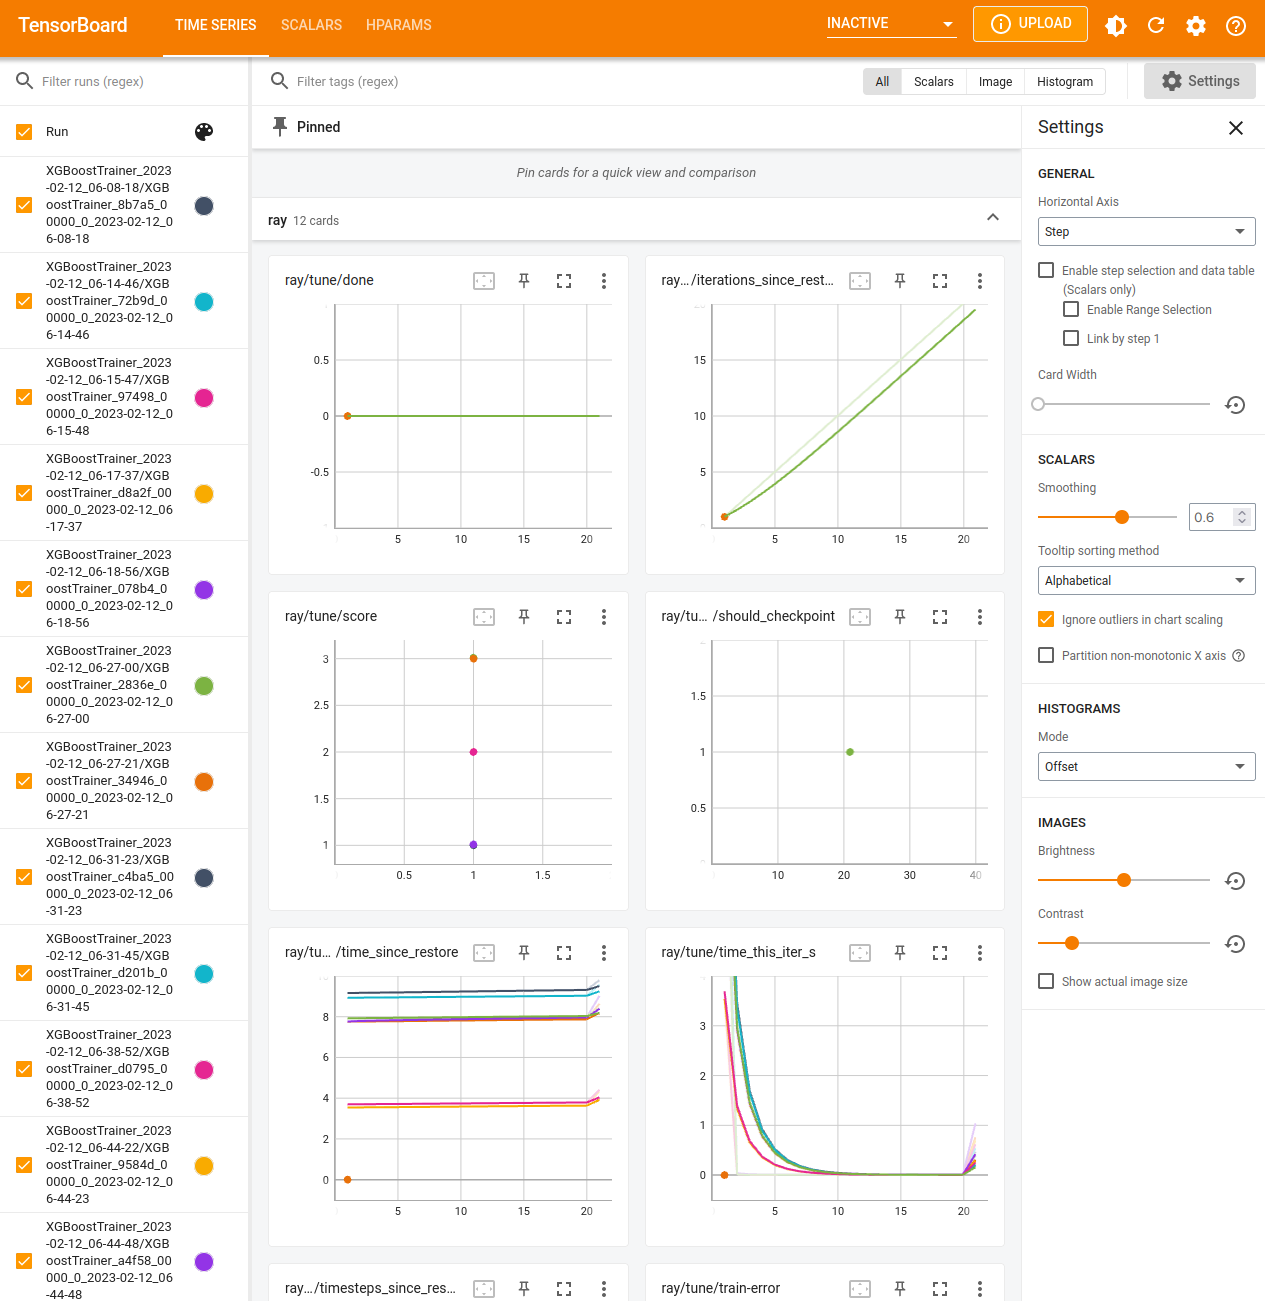

## **Ray Serve**

In [79]:
import requests 
from starlette.requests import Request
from typing import Dict

from sklearn.datasets import load_iris
from sklearn.ensemble import GradientBoostingClassifier

from ray import serve

In [80]:
iris_dataset = load_iris()
model = GradientBoostingClassifier()
model.fit(iris_dataset["data"], iris_dataset["target"])

GradientBoostingClassifier()

In [87]:
@serve.deployment(route_prefix="/iris")
class BoostingModel:
    def __init__(self, model):
        self.model = model
        self.label_list = iris_dataset["target"].tolist()
    
    async def __call__(self, request: Request) -> Dict:
        payload = (await request.json())["vector"]
        print(f"Received http request with data {payload}")

        prediction = self.model.predict([payload])[0]
        human_name = self.label_list[prediction]
        return {"result": human_name}


In [88]:
serve.run(BoostingModel.bind(model))

(ServeController pid=202997) INFO 2023-02-12 08:21:10,263 controller 202997 deployment_state.py:1214 - Stopping 1 replicas of deployment 'BoostingModel' with outdated versions.
(ServeController pid=202997) INFO 2023-02-12 08:21:12,429 controller 202997 deployment_state.py:1310 - Adding 1 replica to deployment 'BoostingModel'.


RayServeSyncHandle(deployment='BoostingModel')

In [89]:
sample_request_input = {"vector": [1.2, 1.0, 1.1, 0.9]}
response = requests.get(
    "http://localhost:8000/iris", json=sample_request_input)
print(response.text)

{"result": 0}
(ServeReplica:BoostingModel pid=209265) Received http request with data [1.2, 1.0, 1.1, 0.9]


(HTTPProxyActor pid=203049) INFO 2023-02-12 08:21:16,246 http_proxy 192.168.1.7 http_proxy.py:361 - GET /iris 200 4.7ms
(ServeReplica:BoostingModel pid=209265) INFO 2023-02-12 08:21:16,244 BoostingModel BoostingModel#esnpBg replica.py:505 - HANDLE __call__ OK 0.8ms


## **Ray Core**

In [91]:
import ray
ray.init(ignore_reinit_error=True)

@ray.remote
def f(x):
    return x * x

futures = [f.remote(i) for i in range(4)]
print(ray.get(futures))

2023-02-12 08:22:43,353	INFO worker.py:1370 -- Calling ray.init() again after it has already been called.


[0, 1, 4, 9]


In [93]:
import ray

@ray.remote
class Counter(object):
    def __init__(self):
        self.n = 0

    def increment(self):
        self.n += 1

    def read(self):
        return self.n

counters = [Counter.remote() for i in range(4)]
[c.increment.remote() for c in counters]
futures = [c.read.remote() for c in counters]
print(ray.get(futures))

[1, 1, 1, 1]


In [94]:
ray.shutdown()